In [38]:
import torch
import logging
import sys

from model.vision_transformer_utils import (
    WarmupCosineSchedule,
    CosineWDSchedule)
from model.vision_transformer_utils import trunc_normal_, init_opt, apply_masks_targets
from model.ijepa_utils import AverageMeter
from model.vision_transformer import VisionTransformer, VisionTransformerPredictor

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()



def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        msg = encoder.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        msg = predictor.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            msg = target_encoder.load_state_dict(pretrained_dict)
            logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading optimizer
        if opt is not None:
            opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        logger.info(f'loaded optimizers from epoch {epoch}')
        logger.info(f'read-path: {r_path}')
        del checkpoint

    except Exception as e:
        logger.info(f'Encountered exception when loading checkpoint {e}')
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch


In [39]:
def generateMasks(data):
    # :param data: tensor of shape [B, R, C, D]
    # :returns: (data, 1x masks_enc, 4x masks_pred)
    import numpy as np
    # grid_pd = np.load(r"E:\estudy\ST-SSL\code\ST-SSL\data\NYCTaxi\grid_pd.npy")
    # _pd = grid_pd.flatten()
    B, R, C, D = data.size()

    # Initialize masks
    masks_enc = torch.zeros(B, R, C, dtype=torch.uint8)
    masks_pred = torch.zeros(4, B, R, C, dtype=torch.uint8)

    ## select size of context and target masks before sample loop.
    ## grid_size: 20x10
    
    masks_enc = masks_enc.flatten(1)
    masks_pred = masks_pred.flatten(2)
    # ctxt_size = torch.randint(50, 100, (1,)).item()       ## low (inclusive), high (exclusive)
    # trgt_size = torch.randint(50//4, 100//4, (1,)).item()  
    ctxt_size = torch.randint(30, 70, (1,)).item()       ## low (inclusive), high (exclusive)
    leftOutNodes = R*C - ctxt_size
    trgt_size = torch.randint(2*leftOutNodes//3, leftOutNodes, (1,)).item()  
    # print(f"ctxt_size: {ctxt_size}, trgt_size: {trgt_size}")
    # print(f"masks_enc.shape: {masks_enc.shape}, masks_pred.shape: {masks_pred.shape}")  ##m asks_enc.shape: torch.Size([32, 200]), masks_pred.shape: torch.Size([4, 32, 200])
    _try=0
    for b in range(B):
        # pd = _pd.copy()
        # print(f"\n\ncxtz: {ctxt_size}")
        # ctxt_indices = np.random.choice(R*C, size=ctxt_size, replace=False, p=pd)
        ctxt_indices = np.random.choice(R*C, size=ctxt_size, replace=False)
        available_indices = np.setdiff1d(np.arange(R*C), ctxt_indices)
        # print(f"mask_enc.shape: {masks_enc.shape} ")
        # print(f"mask_enc.shape: {masks_enc.shape} ")
        masks_enc[b, ctxt_indices] = 1 
        # pd[ctxt_indices] = 0           ## set ctxt indices to 0 so that those nodes are not repeated in trgt masks
        # pd /= pd.sum()
        # Generate four prediction masks (can be overlapping with each other, but not with context mask)
        for i in range(4):
            # Smaller random sizes for prediction masks
            trgt_indices = np.random.choice(available_indices, size=trgt_size, replace=False)
            # trgt_indices = np.random.choice(R*C, size = trgt_size, replace=False, p=pd) 
            masks_pred[i, b, trgt_indices] = 1
    masks_enc = masks_enc.view(B, 1, R*C)
    masks_pred = masks_pred.view(4, B, R*C)
    return (data, masks_enc, masks_pred.transpose(0, 1))



!!Scaling is NOT off!!


data['x_train'].shape:  (3023, 19, 128, 2) (3023, 1, 128, 2) 

!!train shuffle is True!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 299
INFO:root:read-path: D:\omer\ST-SSL\logs\NYCBike1_lpe_shared\jepa-ep300.pth.tar


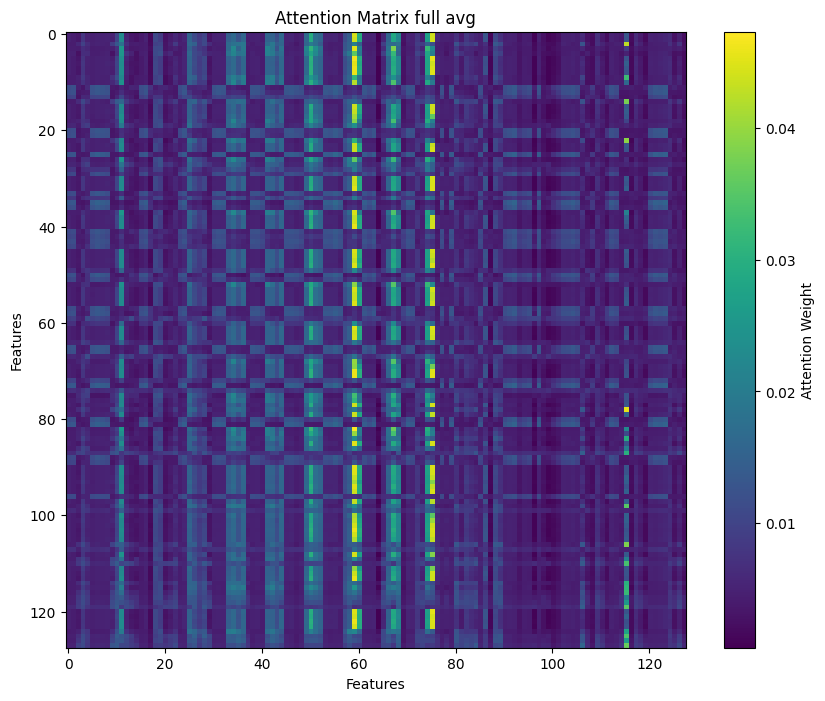

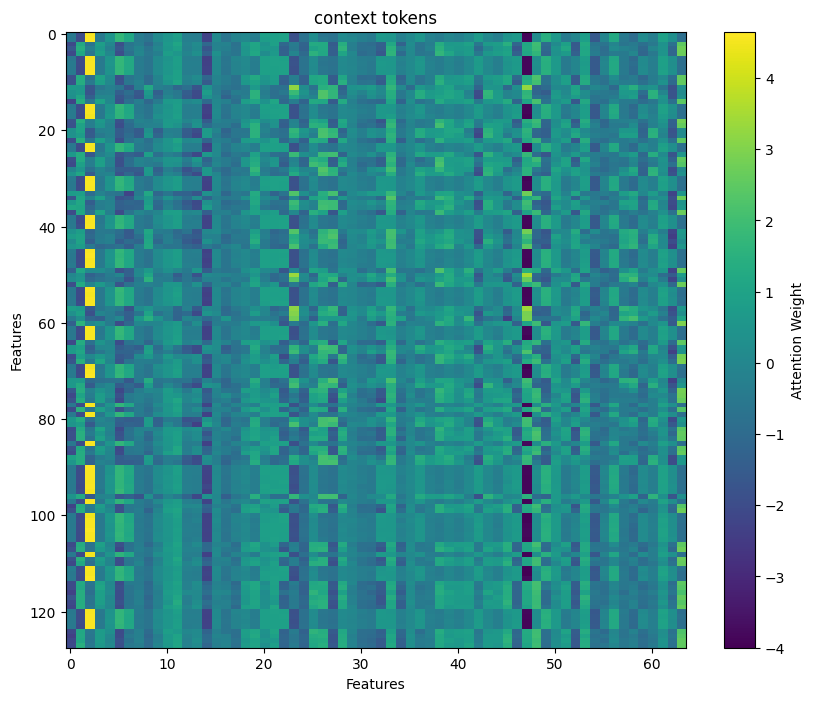

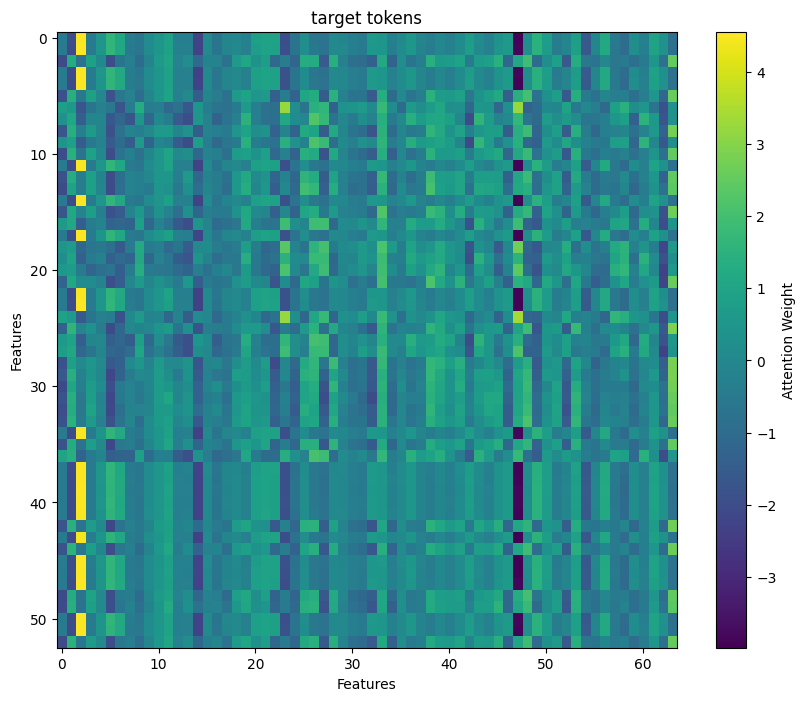



!!Scaling is NOT off!!


data['x_train'].shape:  (3023, 19, 128, 2) (3023, 1, 128, 2) 

!!train shuffle is True!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 299
INFO:root:read-path: D:\omer\ST-SSL\logs\NYCBike1_lpe_shared\jepa-ep300.pth.tar


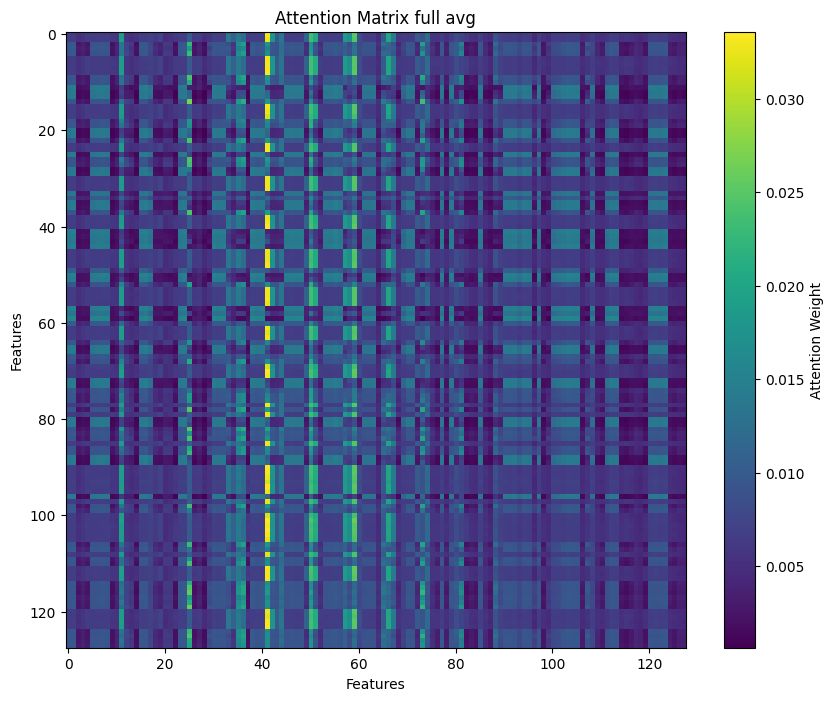

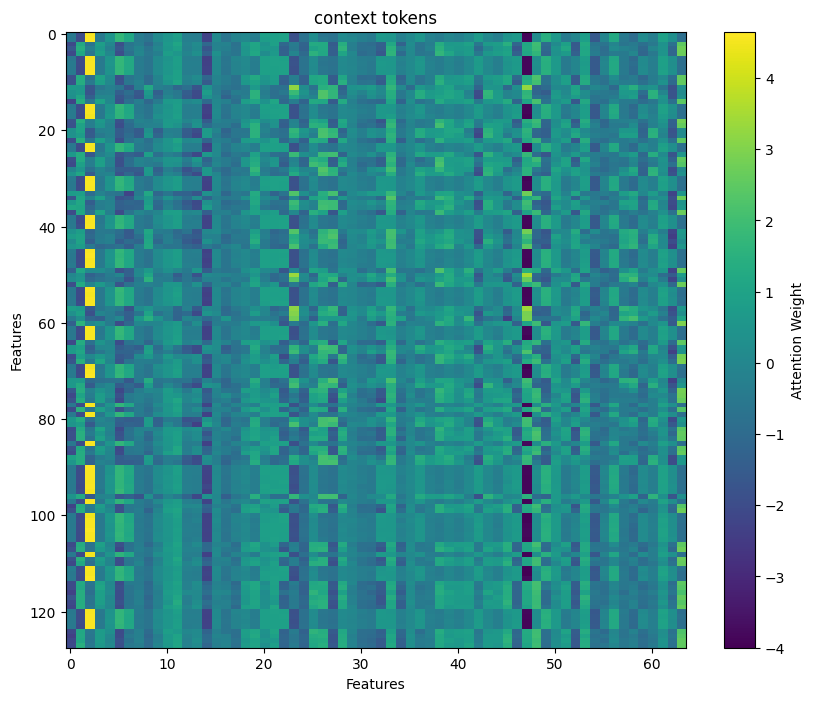

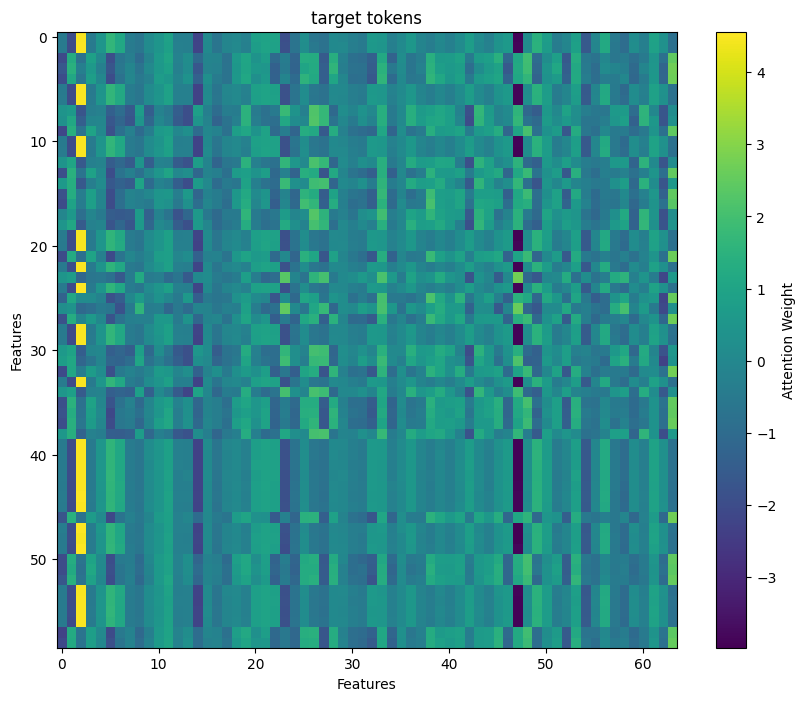



!!Scaling is NOT off!!


data['x_train'].shape:  (3023, 19, 128, 2) (3023, 1, 128, 2) 

!!train shuffle is True!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 299
INFO:root:read-path: D:\omer\ST-SSL\logs\NYCBike1_lpe_shared\jepa-ep300.pth.tar


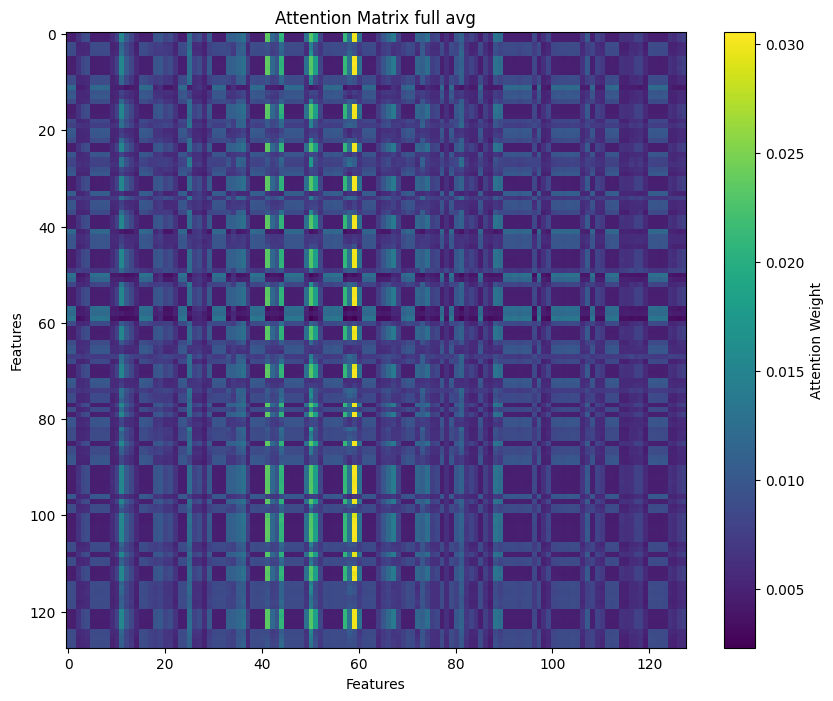

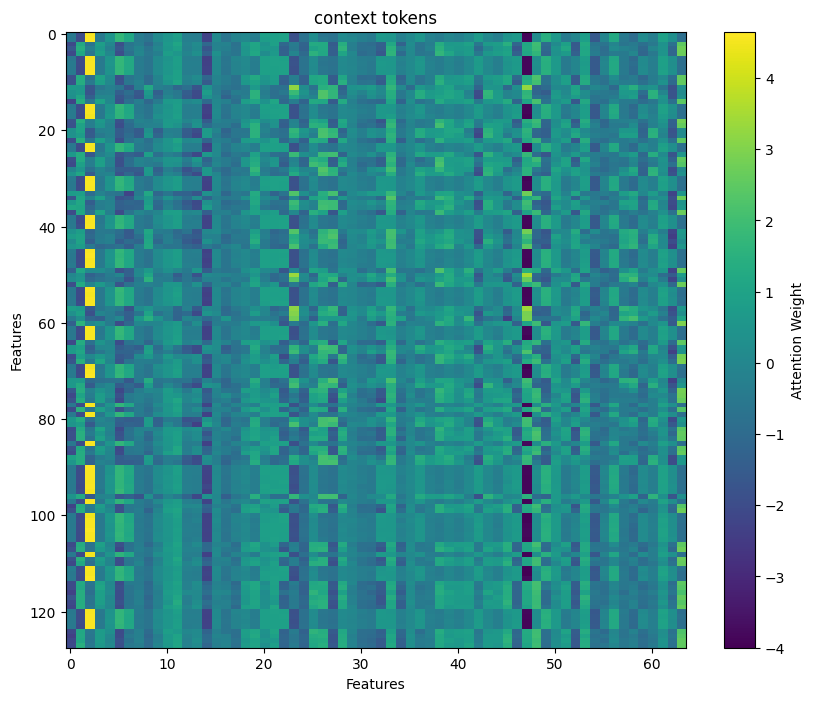

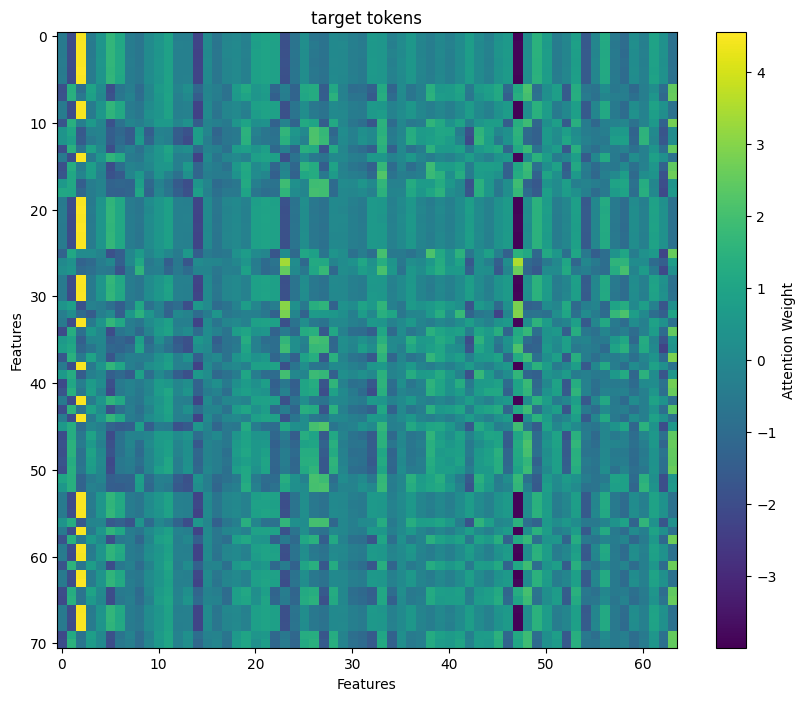



!!Scaling is NOT off!!


data['x_train'].shape:  (3023, 19, 128, 2) (3023, 1, 128, 2) 

!!train shuffle is True!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 299 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 299
INFO:root:read-path: D:\omer\ST-SSL\logs\NYCBike1_lpe_shared\jepa-ep300.pth.tar


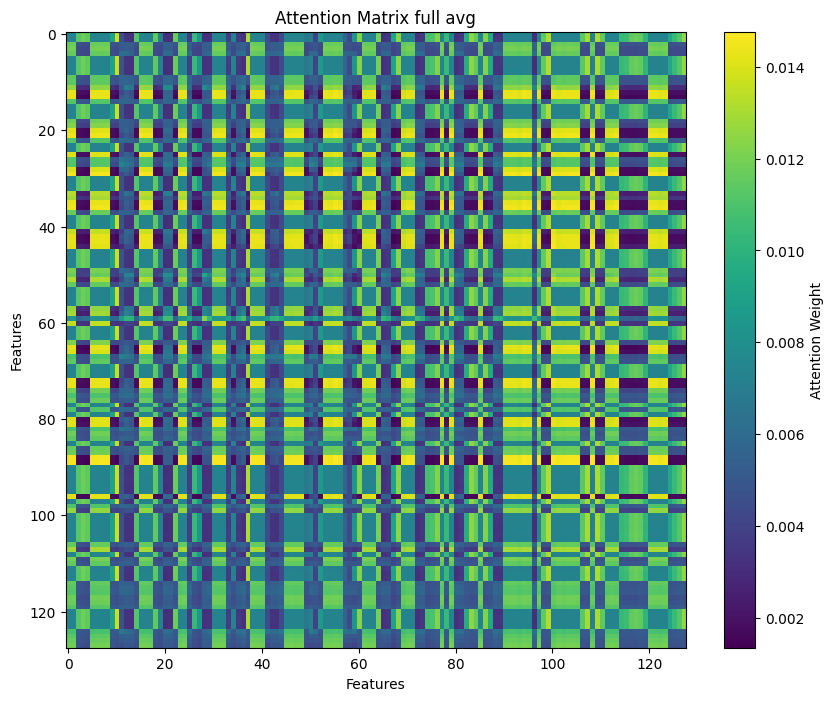

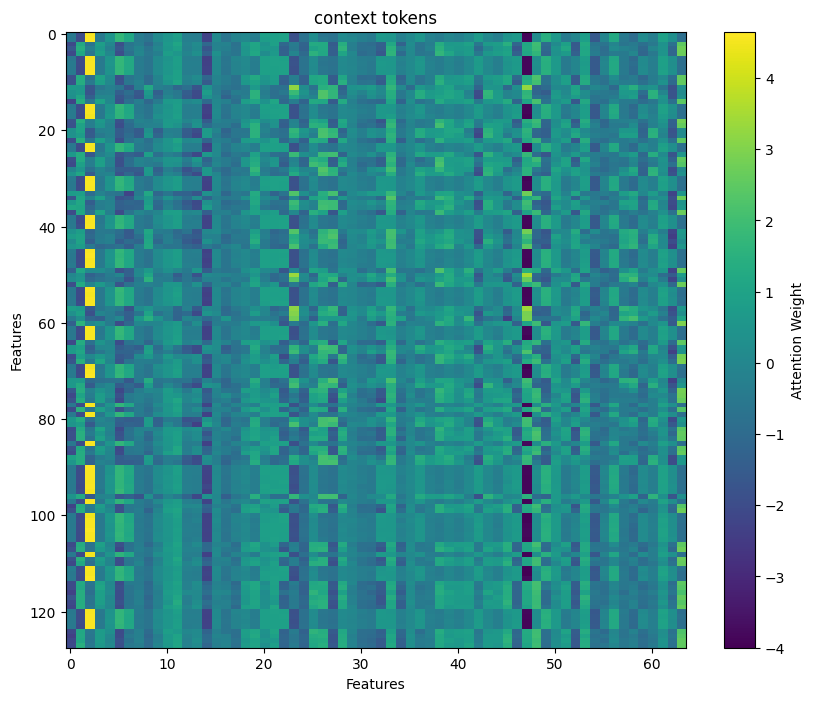

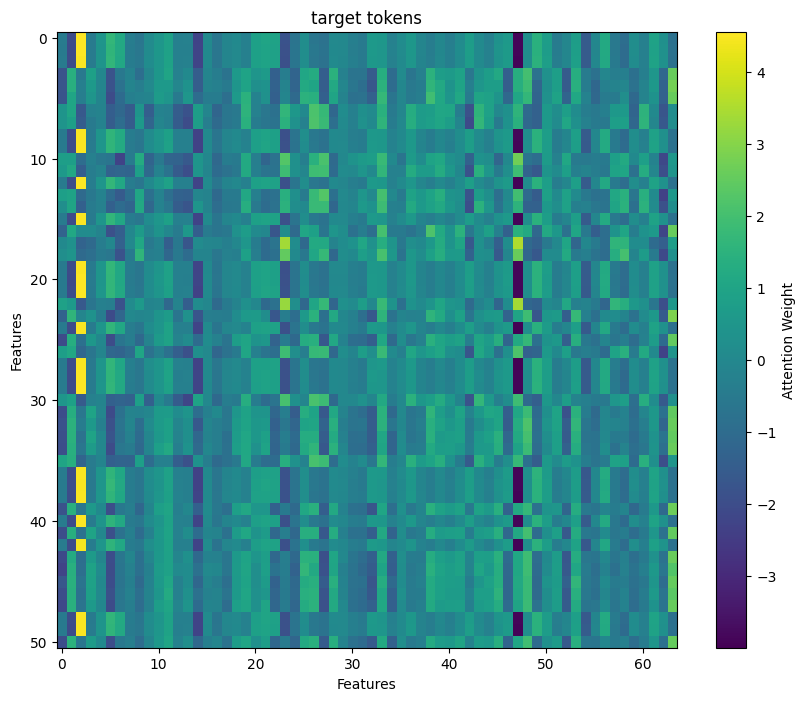

average_att1.shape: (128, 128)
average_att_mean.shape: (128, 128)


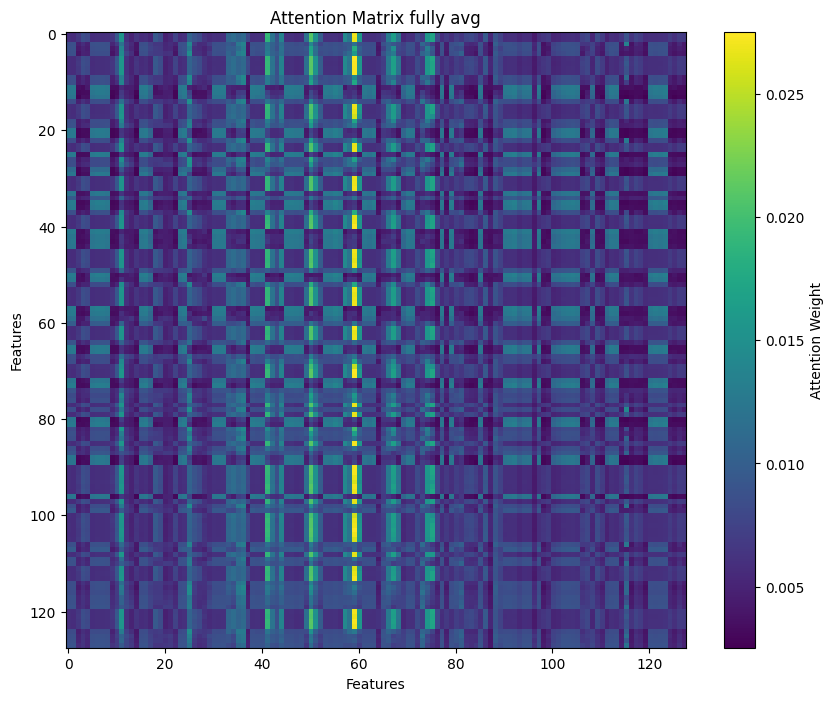

In [56]:
def plot_adj(path, l):
    load_model=True
    import time
    import yaml
    import sys
    import torch
    
    sys.path.append('.')
    sys.path.append('..')
    from lib.dataloader import get_dataloader
    args = {"data_dir": r"data", "dataset": "NYCBike1", "batch_size": 1, "test_batch_size": 1, "rows": 16, "cols": 8, "num_epochs": 100}
    dataloader = get_dataloader(
        data_dir=args['data_dir'], 
        dataset=args['dataset'], 
        batch_size=args['batch_size'], 
        test_batch_size=args['test_batch_size'],
        scalar_type='Standard'
    )
    train_loader = dataloader['train']
    test_loader = dataloader['test']
    val_loader = dataloader['val']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = VisionTransformer(
        img_size=(args["rows"], args["cols"]),
        patch_size=1,
        in_chans=38,
        embed_dim=64,
        predictor_embed_dim=None,
        depth=4,
        predictor_depth=None,
        num_heads=4,
        mlp_ratio=4,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.4,
        attn_drop_rate=0.4,
        drop_path_rate=0.3,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )
    predictor = VisionTransformerPredictor(
        img_size=(args["rows"], args["cols"]),
        embed_dim=64,
        predictor_embed_dim=64//2,
        depth=1,
        num_heads=4,
        mlp_ratio=4,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.4,
        attn_drop_rate=0.4,
        drop_path_rate=0.3,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )

    import copy
    target_encoder = copy.deepcopy(encoder)
    encoder.eval().to(device)
    predictor.eval().to(device)
    target_encoder.eval().to(device)




    wd = 0.04
    final_wd = 0.4
    start_lr = 0.0002
    final_lr = 1.0e-06
    lr = 0.001
    ipe = len(train_loader)
    warmup = 40
    ipe_scale = 1.0
    use_bfloat16 = True
    optimizer, scaler, scheduler, wd_scheduler = init_opt(
            encoder=encoder,
            predictor=predictor,
            wd=wd,
            final_wd=final_wd,
            start_lr=start_lr,
            ref_lr=lr,
            final_lr=final_lr,
            iterations_per_epoch=ipe,
            warmup=warmup,
            num_epochs=args["num_epochs"],
            ipe_scale=ipe_scale,
            use_bfloat16=use_bfloat16)

    ema = [0.996, 1.0]
    ipe = len(train_loader)
    ipe_scale = 1.0
    momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*args["num_epochs"]*ipe_scale)
                            for i in range(int(ipe*args["num_epochs"]*ipe_scale)+1))
    
    if load_model:
        encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
            device=device,
            r_path=path,
            encoder=encoder,
            predictor=predictor,
            target_encoder=target_encoder,
            opt=optimizer,
            scaler=scaler)
        for _ in range(start_epoch*ipe):
            scheduler.step()
            wd_scheduler.step()

            # next(momentum_scheduler)
    ## just get the attention maps from the context_encoder (input whole image)
    # for _shared
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # data = data[:, 0, :, :].squeeze(1)
            B, T, N, D = data.size()
            data = data.transpose(1, 2).reshape(B, N, -1)
            B, N, D = data.size()
            ogX = data.clone()
            data = data.view(B, args["rows"], args["cols"], D).to(device)
            
            imgs, masks_enc, masks_pred = generateMasks(data)
            imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
            # print(f"imgs.sum: {imgs.sum(axis=(1)).flatten(2)}")
            masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
            masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
            
            #  see whole image as context 
            masks_enc=torch.ones_like(masks_enc)
            # masks_enc=torch.zeros_like(masks_enc)
            # masks_enc[:, :, 0:2] = 1
            def forward_context():    ## mask context tokens before encoding
                z, pe, attn_list, upX, beforePosX, posX = encoder(imgs, masks=masks_enc, pe=None)  ## VisionTransformer
                return z, pe, attn_list, upX, beforePosX, posX
            def forward_target(pe):
                z, _, attn_list, _, _, _ = target_encoder(imgs, masks=None, pe=pe)  ## VisionTransformer
                z = apply_masks_targets(z, masks_pred)
                return z, attn_list
            zc, pe, attn_list_1, upX, beforePosX, posX = forward_context()  # Context encoder forward pass
            zt, _ = forward_target(pe)  # Target encoder forward pass
            zp = predictor(zc, masks_enc, masks_pred, pe=pe)   ## VisionTransformerPredictor
            break
    
    """
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # data = data[:, 0, :, :].squeeze(1)
            B, T, N, D = data.size()
            data = data.transpose(1, 2).reshape(B, N, -1)
            B, N, D = data.size()
            ogX = data.clone()
            data = data.view(B, args["rows"], args["cols"], D).to(device)
            
            imgs, masks_enc, masks_pred = generateMasks(data)
            imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
            # print(f"imgs.sum: {imgs.sum(axis=(1)).flatten(2)}")
            masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
            masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
            
            # see whole image as context
            masks_enc=torch.ones_like(masks_enc)
            # masks_enc=torch.zeros_like(masks_enc)
            # masks_enc[:, :, 0:2] = 1
            def forward_context():    ## mask context tokens before encoding
                z, attn_list, upX, beforePosX, posX = encoder(imgs, masks=masks_enc)  ## VisionTransformer
                return z, attn_list, upX, beforePosX, posX
            def forward_target():
                z, attn_list, _, _, _ = target_encoder(imgs, masks=None)  ## VisionTransformer
                z = apply_masks_targets(z, masks_pred)
                return z, attn_list
            zc, attn_list_1, upX, beforePosX, posX = forward_context()  # Context encoder forward pass
            zt, _ = forward_target()  # Target encoder forward pass
            zp = predictor(zc, masks_enc, masks_pred)   ## VisionTransformerPredictor
            break
    """

    import matplotlib.pyplot as plt

    # Generate the same 200x200 attention matrix
    # np.random.seed(42)
    # print(zc.shape)
    
    
    imgs = imgs[0].squeeze(0).flatten(1).T.sum(axis=1).unsqueeze(1).cpu().numpy()
    


    # for h in range(4):
    #     attn = attn_list_1[l][0].squeeze(0).squeeze(0).softmax(-1).cpu().numpy()[:,:][h, ...]
    #     # Create a static heatmap using Matplotlib
    #     plt.figure(figsize=(10, 8))
    #     plt.imshow(attn, cmap='viridis', aspect='auto')
    #     plt.colorbar(label='Attention Weight')
    #     plt.title(f'Attention Matrix head {h}')
    #     plt.xlabel('Features')
    #     plt.ylabel('Features')
    #     plt.show()
    import numpy as np
    att = attn_list_1[l][0].squeeze(0).squeeze(0).softmax(-1).cpu().numpy()[:,:]
    average_att = np.mean(att, axis=0)
    plt.figure(figsize=(10, 8))
    plt.imshow(average_att, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title(f'Attention Matrix full avg')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()



    # attn1 = attn_list_1[l][1].squeeze(0).squeeze(0).cpu().numpy()[:,:]
    # # Create a static heatmap using Matplotlib
    # plt.figure(figsize=(10, 8))
    # plt.imshow(attn1, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('Attention Matrix')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    # plt.figure(figsize=(10, 158))
    # plt.imshow(imgs, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('x')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # # Iterate over data dimensions and create text annotations.
    # for i in range(imgs.shape[0]):
    #     for j in range(imgs.shape[1]):
    #         plt.text(j, i, f'{imgs[i, j]:.2f}', ha='center', va='center', color='w')

    # plt.show()
    
    # print(f"qk.shape: {upX.shape}")
    # q = qk[0][0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(q, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('query matrix')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    # k = qk[1][0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(k, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('key matrix')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    
    # ogX = ogX[0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(ogX, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('token matrix before patchification')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    # upX = upX[0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(upX, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('token matrix after patchification')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    
    
    # beforePosX = beforePosX[0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(beforePosX, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('x before pos embed')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()

    # posX = posX[0].squeeze(0).cpu().numpy()
    # plt.figure(figsize=(10, 8))
    # plt.imshow(posX, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('pos embed')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()


    # Create a static heatmap using Matplotlib
    zc = zc[0].squeeze(0).cpu().numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(zc, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('context tokens')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    zt = zt[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(zt, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('target tokens')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    # zp = zp[0].squeeze(0).cpu().numpy()
    # # Create a static heatmap using Matplotlib
    # plt.figure(figsize=(10, 8))
    # plt.imshow(zp, cmap='viridis', aspect='auto')
    # plt.colorbar(label='Attention Weight')
    # plt.title('prediction tokens')
    # plt.xlabel('Features')
    # plt.ylabel('Features')
    # plt.show()
    

    attn=None
    return attn, average_att

e=70
load_path = fr"D:\omer\ST-SSL\logs\NYCBike1_lpe_shared\jepa-ep300.pth.tar"
att, average_att1 = plot_adj(load_path, 0)
att, average_att2 = plot_adj(load_path, 1)
att, average_att3 = plot_adj(load_path, 2)
att, average_att4 = plot_adj(load_path, 3)

import numpy as np
import matplotlib.pyplot as plt

print(f"average_att1.shape: {average_att1.shape}")
average_att_mean = np.mean([average_att1, average_att2, average_att3, average_att4], axis=0)
print(f"average_att_mean.shape: {average_att_mean.shape}")
plt.figure(figsize=(10, 8))
plt.imshow(average_att_mean, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title(f'Attention Matrix fully avg')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


In [ ]:
e=146
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\maskedAttention\jepa-ep{e}.pth.tar"
att = plot_adj(load_path, 0)

In [ ]:

# for i in range(10, 501, 10):
e=388
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\maskedAttention\jepa-ep{e}.pth.tar"
att = plot_adj(load_path, 0)

In [50]:
import numpy as np
# load_path = fr"D:\omer\ST-SSL\data\NYCBike1\adj_lpe_shared_T_T.npz"
np.savez(load_path, adj_mx=att_thresholded)

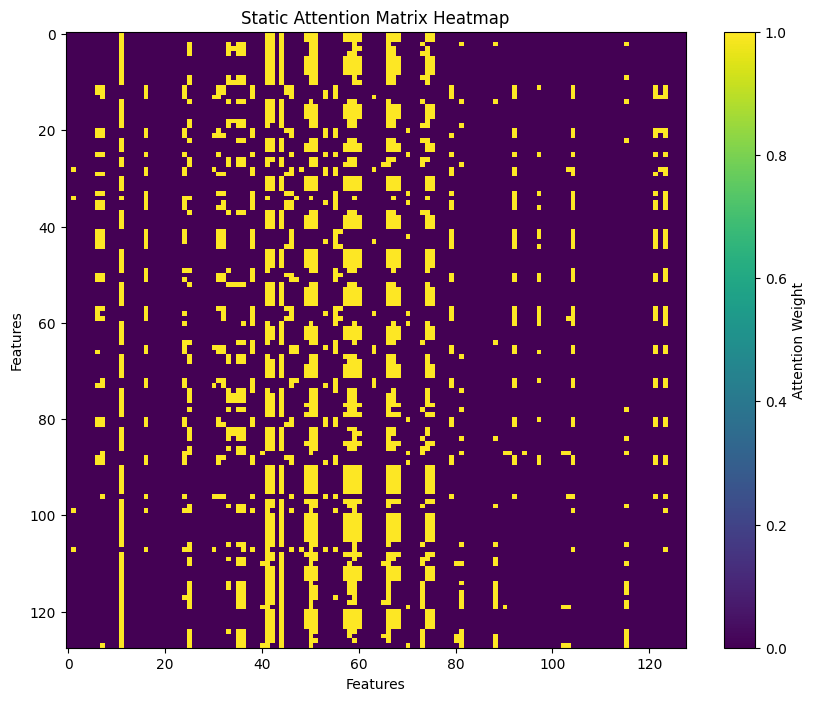

In [49]:
import matplotlib.pyplot as plt
# print(att.shape)
# print(att)
# print(type(att))
plt.figure(figsize=(10, 8))
# att_modifiedSym = (att_modified + att_modified.T) / 2
att_thresholded = att_modified > 0
# plt.imshow(average_att_mean, cmap='viridis', aspect='auto')
plt.imshow(att_thresholded, cmap='viridis', aspect='auto')
# plt.imshow(att, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title('Static Attention Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show()

In [46]:
import numpy as np

# Assuming att is your 200x200 numpy array
# For demonstration, let's create a sample 200x200 numpy array
np.random.seed(0)  # Seed for reproducibility

# Vectorized approach to keep only the top 8 values in each row
def keep_top_8_vectorized(arr):
    # Shape of the array
    rows, cols = arr.shape

    # Get indices of each element when the array is sorted along each row
    sorted_indices = np.argsort(arr, axis=1)

    # We want to zero out all but the top 8 values, so we select all but the last 8 columns of indices
    threshold_indices = sorted_indices[:, :-16]

    # Copy the array to avoid changing the original data
    result = arr.copy()

    # Flatten the row indices to match the flattened threshold indices
    row_indices = np.arange(rows).reshape(-1, 1)

    # Use advanced indexing to set the unwanted elements to zero
    result[row_indices, threshold_indices] = 0

    return result

# Apply the function
print(average_att_mean.shape)
att_modified = keep_top_8_vectorized(average_att_mean)


(128, 128)


(200, 256)


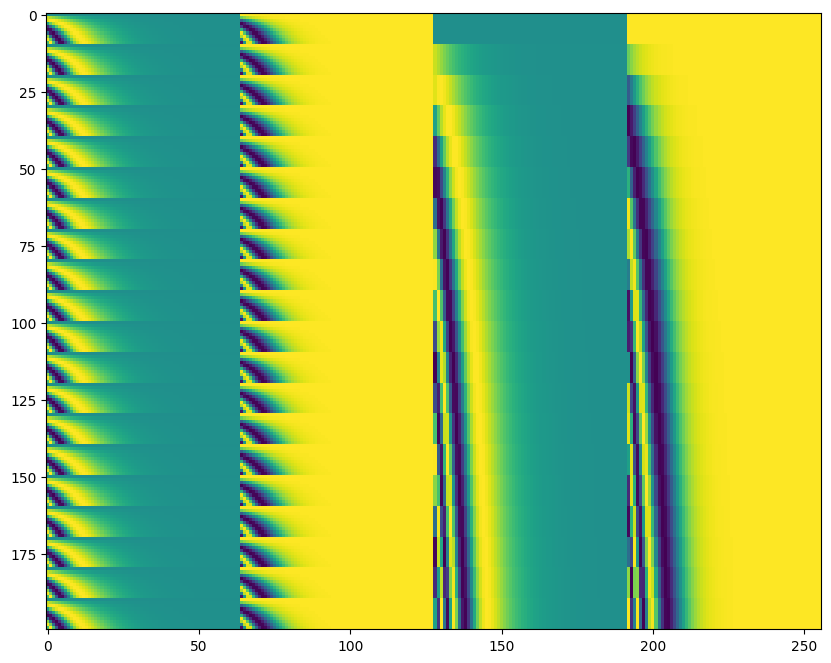

In [9]:
from model.vision_transformer import get_2d_sincos_pos_embed

pos_embed = get_2d_sincos_pos_embed(256, 20, 10)
print(pos_embed.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(pos_embed, cmap='viridis', aspect='auto')

torch.Size([256, 20, 10])


TypeError: Invalid shape (256, 20, 10) for image data

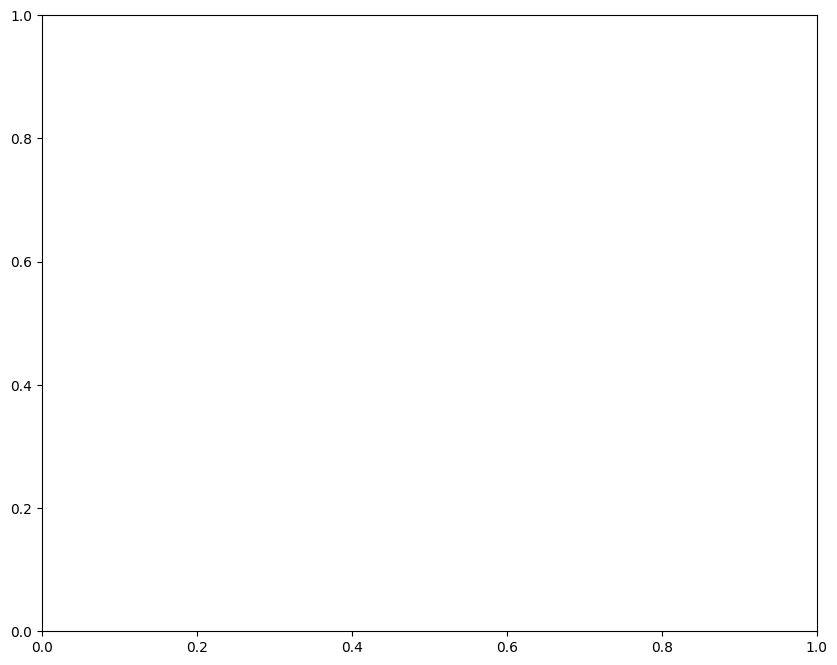

In [11]:
import math
def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe

pos_embed = positionalencoding2d(256, 20, 10)
print(pos_embed.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(pos_embed, cmap='viridis', aspect='auto')

(400, 2048)


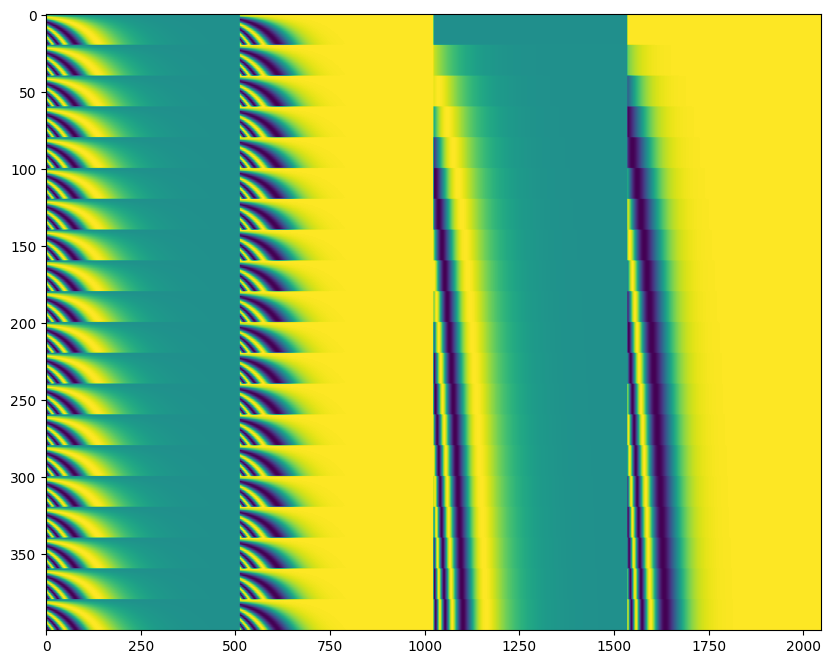

In [15]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

import numpy as np
pos_embed = get_2d_sincos_pos_embed(2048, 20)
print(pos_embed.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(pos_embed, cmap='viridis', aspect='auto')